# 2. (Deep) CNNs for Image Colorization

- AIM: Convert Colored images to grayscale images. We might loss color information, so converting grayscale to colored version is not an easy job.   
    
**K-Means Clustering**
- Take both Train and Test images, and extract BIRD Class Images (6000 Images in total) i.e. 6000x32x32 pixels   
   
- Choose 10% of pixels randomly. You'll have pixels between [614400, 6144000] pixels. Each pixel is an RGB with 3 elements.   
   
- Run K-Means clustering on K = 4. Centers of clusters will be your main colors. Convert the colored images to k-color images by converting each pixel's value to the closest main color. Each pixel would fall into one of those k classes.   
    
**CNN**
- Use any tool to obtain grayscale 32x32x1 images from 32x32x3 images. The grayscale images are input of your CNN Network.   
   
- 2 or more Conv Layers, 2 or more MLP layers, 5x5 filters, Softmax output.   
   
- Determine no. of filters, strides, and padding parameters yourself. Use one max pooling Layer minimum.   
   
- Use a Classification schema, to determine one of the 4 color classes for each pixel in your grayscale images.   
   
Input: Grayscale image i.e. 32x32x1   
Output: 32x32x4 - It will assign one of the k=4 color classes for each pixel, therefore each of the pixels is classified into one of the classes.   
    
- After each pixel is classified into one of the main colors, the RGB code of that color can be assigned to the pixel.   
eg. If third main color is [255 255 255] and pixel is (32, 32) of an image has one-hot encoded class of [0,0,1,0] i.e. it was classified as third color, the output of the Conv part c1xc2 depends on the size of the convoluntional layers you choose and is a feature map, which is a matrix.   
   
- That matrix must be flattened or reshaped i.e. must be turned into a vector of size c1xc2x1, before it is fed into MLP part.   
   
- Choose no. of Neurons for the first layer of MLP and any other hidden layers, if you are willing to add more than one hidden layer!   
   
- Last Layer **MUST** have 32x32x4 = 4096 Neurons, each of which represents a pixel of being one of k=4 classes.   
   
- Add Softmax layer, which will be choose the highest value of its' k = 4 inputs for each of 1024 pixels, therefore, the output of MLP has to be reshaped into a 32x32x4 matrix, and to get the colored image, the RGB vector of each of the k=4 classes has to converted to the RGB vector, so an output image will be 32x32x3.   
   
- Train for atleast 5 epochs (30 recommended). Plot Training, validation and Test errors in each epoch.    
    
- Report Train and Test errors and visually compare the artifically colored versions of the first 10 images in the test set with the original images.  

### K-Means Clustering

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import warnings; warnings.simplefilter('ignore')
import random
import os

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
def extract_images():
    folder = 'cifar-10-batches-py'
    
    files = ['data_batch_1', 'data_batch_2', 'data_batch_3',
            'data_batch_4', 'data_batch_5', 'test_batch']
    
    X = []
    for each in files:
        images = unpickle(os.path.join(folder, each))
        all_img = images[b'data'].reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype('uint8')
        
        for i in range(len(all_img)):
            if(images[b'labels'][i] == 2):
                X.append(all_img[i])
    
    return X

In [6]:
img_list = extract_images()
len(img_list)

6000

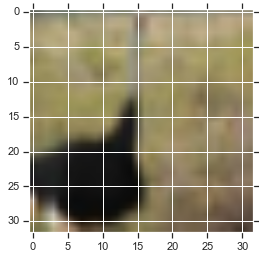

In [7]:
plt.imshow(img_list[15])

In [8]:
for j in range(len(img_list)):
    each = img_list[j]
    each = each / 255.0
    if(j == 0):
        dataa = each.reshape(32*32, 3)
    else:
        dataa = np.append(dataa, each.reshape(32*32, 3), axis=0)


NameError: name 'data' is not defined

In [9]:
print(dataa.shape)

(6144000, 3)


In [14]:
extract = np.random.randint(low=0, high=6144000, size=614400)

In [16]:
data = [dataa[each] for each in extract]

In [19]:
data = np.array(data)

In [20]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

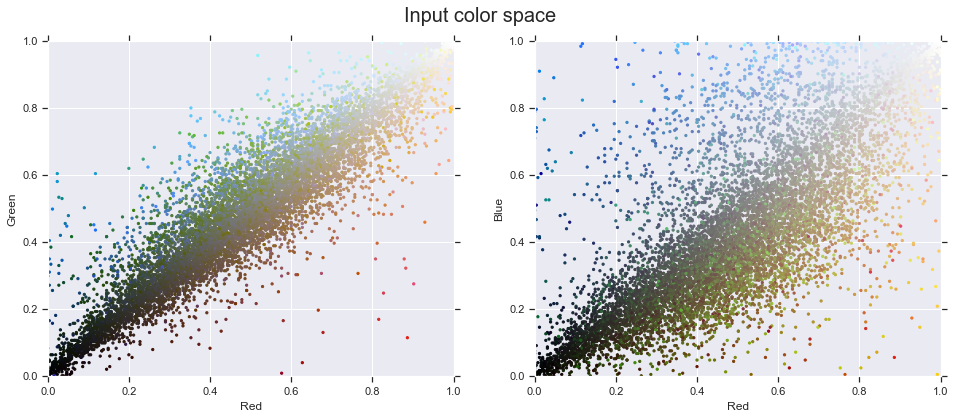

In [21]:
plot_pixels(data, title='Input color space')

In [22]:
kmeans = KMeans(4)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

In [49]:
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

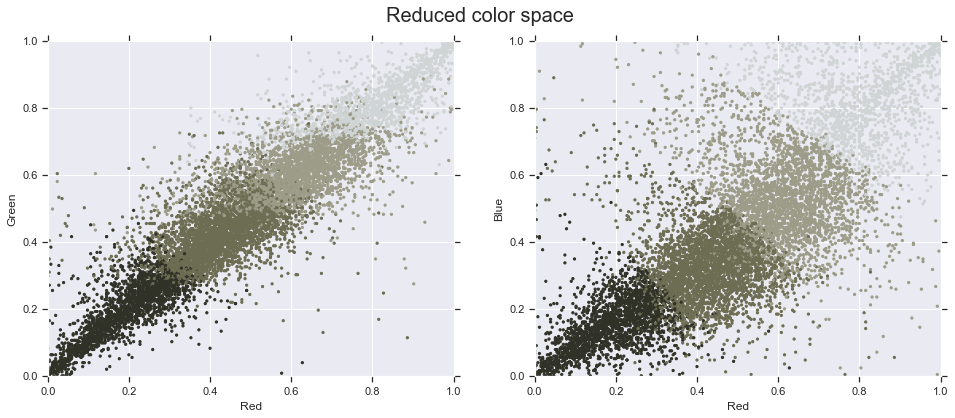

In [50]:
plot_pixels(data, colors=new_colors, title='Reduced color space')

In [66]:
img = img_list[1000]
img = img / 255.0
dataa = img.reshape(32*32, 3)
pred = kmeans.predict(dataa)

In [68]:
set(pred)

{0, 2, 3}

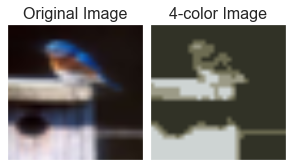

In [69]:
#kmeanss = KMeans(4)
img = img_list[1]
img = img / 255.
dataa = img.reshape(32*32, 3)
#kmeanss.fit(dataa)
new_colorss = kmeans.cluster_centers_[kmeans.predict(dataa)]

recolored = new_colorss.reshape(32, 32, 3)

fig, ax = plt.subplots(1, 2, figsize=(5, 5),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(img)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(recolored)
ax[1].set_title('4-color Image', size=16)

In [70]:
###----------------- PREDICTED VALUES FOR PIXELS

In [110]:
a = kmeans.predict(data)

In [111]:
set(a)

{0, 1, 2, 3}

In [229]:
data[3], a[3]

(array([0.50588235, 0.61960784, 0.45098039]), 3)

In [336]:
new_colors[2], a[2]

(array([0.48482199, 0.47752358, 0.36457926]), 3)

In [335]:
new_colors[3], a[3]

(array([0.48482199, 0.47752358, 0.36457926]), 3)

### Convolutional Neural networks

In [71]:
import skimage
from skimage import io
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)

In [72]:
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam

Using TensorFlow backend.


In [73]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
K.set_image_dim_ordering('tf')

In [74]:
def preprocess_images(img):
    img1 = cv2.resize(img, (32, 32))
    return img1

In [97]:
def train_test():
    folder = 'cifar-10-batches-py'
    
    files = ['data_batch_1', 'data_batch_2', 'data_batch_3',
            'data_batch_4', 'data_batch_5', 'test_batch']
    
    x_train_img_list = []
    y_train_img_list = []
    for each in files:
        images = unpickle(os.path.join(folder, each))
        all_img = images[b'data'].reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype('uint8')
        
        for i in range(len(all_img)):
            if(images[b'labels'][i] == 2):
                im = all_img[i] / 255.
                nn = np.resize(im, (32, 32, 1))
                x_train_img_list.append(nn)
                y_train_img_list.append(kmeans.predict(im.reshape(32*32, 3)))
    
    return x_train_img_list, y_train_img_list

In [98]:
x_train, y_train = train_test()

In [102]:
x = np.array(x_train)
y = np.array(y_train)

In [103]:
x.shape, y.shape

((6000, 32, 32, 1), (6000, 1024))

In [101]:
img_rows = 32
img_cols = 32
num_channels = 1
num_epochs = 5
batch_size = 20

save_folder = 'CNNModel'

num_classes = 4

In [104]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2)
X_train = x[:-1000]
y_train = y[:-1000]
X_test = x[-1000:]
y_test = y[-1000:]

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [116]:
y_train = y_train.reshape((5000, 32*32*4))
y_test = y_test.reshape((1000, 32*32*4))

In [117]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5000, 32, 32, 1), (5000, 4096), (1000, 32, 32, 1), (1000, 4096))

In [118]:
input_shape = X_train[0].shape
print(input_shape)

(32, 32, 1)


In [112]:
#new_colors[3], a[3]
dic = {}
for i in range(len(new_colors)):
    dic[a[i]] = new_colors[i]
print(dic)

{0: array([0.42831437, 0.42680111, 0.32463888]), 1: array([0.1933036 , 0.19710509, 0.15177616]), 2: array([0.81135856, 0.83196076, 0.83038889]), 3: array([0.61277689, 0.61074816, 0.53293896])}


In [ ]:
model = Sequential()

model.add(Conv2D(32, (5, 5), strides=1, padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (5, 5), strides=1, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(10000))
model.add(Activation('relu'))
model.add(Dense(6000))
model.add(Activation('relu'))
model.add(Dense(4096))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=2e-4), metrics=['accuracy'])

model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
activation_12 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0         
__________

**A Summary of what I did so far:**   

- Using the KMeans Algorithm, I successfully generated 4 clusters. So, now I have 4 Cluster centers.   
- Each pixel is close to one center.   
- Now, CNN comes into picture. The labels of the KMeans were used as the class labels for the CNN Model.    
- Original size images are plugged in the model. In terms of 'y', we convert it into 4096 i.e. one numpy array per image.   
- You then reshape that Numpy array in blocks of 4, to see which cluster has been assigned to each of them. Here, we have flattened the image and doing pixel-by-pixel classification.   
- Once we get what label is assigned to each pixel, we just replace the label with its' cluster center.  

In [ ]:
# visualizing losses and accuracy for Train and Validation Sets
train_acc=hist.history['acc']
train_loss=hist.history['loss']
xc=range(num_epoch)

plt.figure(figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,train_loss)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('Train Acc and Loss')
plt.grid(True)
plt.legend(['Accuracy','Loss'])

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print("Predicted y class probabilities: ", model.predict(test_image))
print("Predicted Class: ", model.predict_classes(test_image))